In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

In [2]:
import idx2numpy
#file = 'MNIST inputs/train-images.idx3-ubyte'
#X = idx2numpy.convert_from_file(file)

file = 'MNIST inputs/t10k-images.idx3-ubyte'
Xtest = idx2numpy.convert_from_file(file)
Xtest = Xtest.reshape((10000, 784))
np.savez_compressed('Xtest', arr = Xtest)

In [3]:
X = np.load('newX.npz')
X = X['arr']
X = X.reshape((600000, 784))
X.shape

(600000, 784)

In [4]:
Xtest = np.load('Xtest.npz')
Xtest = Xtest['arr']
Xtest.shape

(10000, 784)

In [20]:
# X = preprocessing.scale(X)
X /= np.max(X)
Xtest = Xtest.astype('float64')
Xtest /= np.max(Xtest)

In [6]:
# ctrl /
# file = 'MNIST inputs/train-labels.idx1-ubyte'
# y = idx2numpy.convert_from_file(file)
# arr = y
# for j in range(9):
#     arr = np.concatenate((arr, y), axis=0)
# np.save('newy.npy', arr)

file = 'MNIST inputs/t10k-labels.idx1-ubyte'
ytest_temp = idx2numpy.convert_from_file(file)

In [7]:
newy = np.load('newy.npy')
y = np.zeros((newy.shape[0], 10))
for i in range(newy.shape[0]):
    y[i,newy[i]] = 1
del newy

In [8]:
ytest = np.zeros((ytest_temp.shape[0], 10))
for i in range(ytest_temp.shape[0]):
    ytest[i,ytest_temp[i]] = 1
del ytest_temp

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


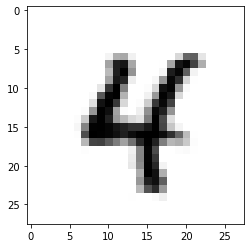

In [9]:
index = 422235
print(y[index])
plt.imshow(X[index].reshape(28,28), cmap=plt.cm.binary)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


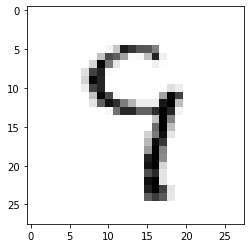

In [10]:
index = 1192
print(ytest[index])
plt.imshow(Xtest[index].reshape(28,28), cmap=plt.cm.binary)

In [11]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def dsigmoid(z):
    return sigmoid(z)*(1-sigmoid(z))

In [12]:
def predict(T, X):
    A1 = sigmoid(X@T[0] + T[1])
    h = sigmoid(A1@T[2] + T[3])
    return np.argmax(h, axis=1)

In [13]:
# https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network
def init_weights(nnSize): # 784 | 100 | 10
#     W1 = (np.random.rand(nnSize[0],nnSize[1])*2-1)* 4*np.sqrt(6/(nnSize[0]+nnSize[1]))
#     b1 = np.zeros((nnSize[1], 1))
#     W2 = (np.random.rand(nnSize[1],nnSize[2])*2-1)* 4*np.sqrt(6/(nnSize[1]+nnSize[2]))
#     b2 = np.zeros((nnSize[2], 1))
    W1 = (np.random.randn(nnSize[0],nnSize[1])/np.sqrt(nnSize[0]))
    b1 = np.random.randn(1, nnSize[1])
    W2 = (np.random.randn(nnSize[1],nnSize[2])/np.sqrt(nnSize[1]))
    b2 = np.random.randn(1, nnSize[2])
    return [W1, b1, W2, b2]

In [14]:
# https://medium.com/better-programming/how-to-build-2-layer-neural-network-from-scratch-in-python-4dd44a13ebba
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py
def cost_function(X, y, T, l): #W1 = T[0], b1 = T[1], W2 = T[2], b2 = T[3]
    Z1 = X@T[0] + T[1]
    A1 = sigmoid(Z1) # m by nnSize[1]
    Z2 = A1@T[2] + T[3]
    h = sigmoid(Z2) # h = A3
    m = X.shape[0]
    J = np.nan_to_num(np.sum(-y*np.log(h)-(1-y)*np.log(1-h))/m + (l/(2*m))*(np.sum(T[0]**2)+np.sum(T[2]**2)))
    #note that biases are not yet regularized
    
    dJ = h - y # m by 10
    dW2 = (A1.T@dJ + l*T[2])/m
    db2 = np.sum(dJ, axis = 0, keepdims=True)/m
    dZ1 = (dJ@T[2].T) * dsigmoid(Z1)
    dW1 = (X.T@dZ1 + l*T[0])/m
    db1 = np.sum(dZ1, axis = 0, keepdims=True)/m
    return J, [dW1, db1, dW2, db2]

In [15]:
def gradient_descent(T, dT, alpha):
    T[0] -= alpha*dT[0]
    T[1] -= alpha*dT[1]
    T[2] -= alpha*dT[2]
    T[3] -= alpha*dT[3]
    return T

In [16]:
def neural_network(X, y, Xcv, ycv):
    nnSize = np.array([784, 120, 10])
    T = init_weights(nnSize)
    cost = []
    test_acc = []
    max_iter = 350
    l = 0.3 #lambda
    alpha = 0.6
    for i in range(max_iter):
        J, dT = cost_function(X, y, T, l)
        T = gradient_descent(T, dT, alpha)
        cost.append(J)
        test_acc.append(accuracy_score(predict(T, Xcv), np.argmax(ycv, axis=1)))
    return T, cost, test_acc

In [21]:
time1 = time.time()
t = np.array([0, 5000]) # Training set
cv = np.array([5000, 6000])
T, cost, test_acc = neural_network(X[t[0]:t[1],:], y[t[0]:t[1],:], X[cv[0]:cv[1],:], y[cv[0]:cv[1],:])
time2 = time.time()
print(time2-time1)

31.035412073135376


In [34]:
def mini_batch_nn(X, y, Xtest, ytest, epoch_size):
    nnSize = np.array([784, 128, 10])
    T = init_weights(nnSize)
    test_acc = []
    max_iter = 25
    l = 0.2 #lambda
    alpha = 0.2
    mini_size = 320
    epoch = 9 # Times epoch_size is looped
    for k in range(max_iter):
        time1 = time.time()
        for j in range(epoch):
            epochX, epochy = X[j*epoch_size:(j+1)*epoch_size, :], y[j*epoch_size:(j+1)*epoch_size, :]
            for i in range(int(np.floor(epoch_size/mini_size))):
                miniX, miniy = epochX[i*mini_size:(i+1)*mini_size, :], epochy[i*mini_size:(i+1)*mini_size, :]
                _, dT = cost_function(miniX, miniy, T, l)
                T = gradient_descent(T, dT, alpha)
            test_acc.append(accuracy_score(predict(T, Xtest), np.argmax(ytest, axis=1)))
        print('Epoch '+str(k+1)+' took:'+ str(time.time() - time1))
    return T, test_acc

In [35]:
t = np.array([0, 540000])
T, test_acc = mini_batch_nn(X[t[0]:t[1],:], y[t[0]:t[1],:], Xtest, ytest, 60000)
time2 = time.time()

Epoch 1 took:12.803280115127563
Epoch 2 took:10.97316575050354
Epoch 3 took:8.497886657714844
Epoch 4 took:8.455047369003296
Epoch 5 took:8.578078746795654
Epoch 6 took:9.441549301147461
Epoch 7 took:8.596299886703491
Epoch 8 took:8.58521318435669
Epoch 9 took:8.554050207138062
Epoch 10 took:8.732998132705688
Epoch 11 took:9.120701313018799
Epoch 12 took:9.209630489349365
Epoch 13 took:9.803444385528564
Epoch 14 took:10.172994613647461
Epoch 15 took:10.041605710983276
Epoch 16 took:10.325854301452637
Epoch 17 took:9.8726966381073
Epoch 18 took:9.415427923202515
Epoch 19 took:9.336990118026733
Epoch 20 took:9.327220678329468
Epoch 21 took:9.360558986663818
Epoch 22 took:9.398691654205322
Epoch 23 took:9.322837829589844
Epoch 24 took:9.31898808479309
Epoch 25 took:9.893951177597046


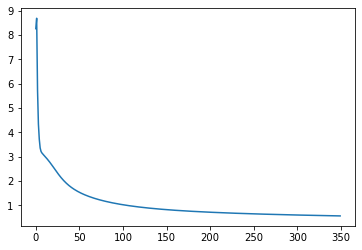

In [29]:
plt.plot(cost)

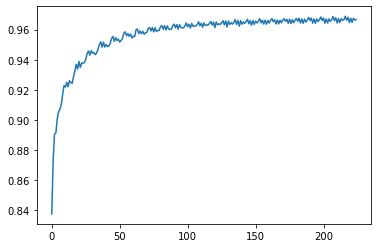

In [36]:
plt.plot(test_acc)

In [37]:
test_acc[-1]

0.9666

In [38]:
accuracy_score(predict(T, Xtest), np.argmax(ytest, axis=1))

0.9666

In [26]:
c = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
d = 2*np.ones((1,3))

In [ ]:
nnSize = np.array([784, 100, 10])
T = init_weights(nnSize)
# l = 0.1
# alpha = 1
# J, dT = cost_function(preprocessing.scale(X[0:600,:]), y[0:600,:], T, l)
# T = gradient_descent(T, dT, alpha)

In [ ]:
# Implementing CNN With Keras
# According to https://www.sicara.ai/blog/2019-10-31-convolutional-layer-convolution-kernel, (Deeper >>> Wider)
# 3x3 and 5x5 are common kernel sizes, and the first layer will usually have a larger kernel
# Use batch normalization rather than dropout

# input size is just input size
# filter size is kernel size
# stride is how far you go
# padding = same | means padding will be even on both sides, one more on left if odd

# Common practice to increase number of filters learned
# Almost always use powers of 2 (¯\_(ツ)_/¯)

# Use categorialCrossEntropy https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
